## Boombikes: bikesharing problem
Boombikes business wants to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the market
*     Which variables are significant in predicting the demands for shred bikes.
*     How well those variables describe the bike demands.

# Introduction


### Import libraries and environment setup

In [1]:
# for data
import pandas as pd
import numpy as np

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set() # Setting seaborn as default style

# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# for statistical and tests
import scipy

# 1. EDA

### Read and understand the data

In [2]:
bike_df = pd.read_csv('day.csv')
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# Check size
bike_df.shape

(730, 16)

In [4]:
# To check nulls and data_type.
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
# Check for any duplicate records
sum(bike_df.duplicated())

0

In [6]:
# Check unique values in all columns
bike_df.nunique().sort_values()

yr              2
holiday         2
workingday      2
weathersit      3
season          4
weekday         7
mnth           12
temp          498
hum           594
casual        605
windspeed     649
registered    678
atemp         689
cnt           695
instant       730
dteday        730
dtype: int64

In [7]:
# Check year spread w.r.t month
bike_df.groupby('yr')['mnth'].count()

yr
0    365
1    365
Name: mnth, dtype: int64

In [8]:
# understanding categorical variable season based on description in data dictionary
bike_df.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [9]:
# understanding categorical variable weekday based on description in data dictionary
bike_df.weekday.value_counts()

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64

In [10]:
# understanding categorical variable weathersit based on description in data dictionary
bike_df.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

### Data pre-processing

In [11]:
'''
Drop unnecessary columns:
instant - unique for each row, somekind of index, possibly primary key of table for SQL lovers.
dteday - unique for each row, shows data for each day. yr and mnth which corresponds to the dteday has been derived from this column and which will be used instead.
casual and registered - The sum of both is shown in cnt which is the dependant variable that we want to understand and predict.
'''
bike_df.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [12]:
'''
Checking if a column can be treated as numerical or categorical variable.
Few of the numerical columns for instance have ordinality but are not continious for this analysis so we have treated it as a categorical variable. 
 Rule: Treat a column as categorical, if the maximum number of unique values  is less than 15 or else its treated as continous numeric.
Create array of variables for  categorical and numerical
'''
def func_variable_type(dtf, col, max_cat=15):
    if (dtf[col].nunique() < max_cat):
        cat_list.append(col)
    else:
        num_list.append(col)

In [13]:
#Call function func_varable_type and print categorical and numeric variable 
cat_list=[]
num_list=[]
dic_cols = {col:func_variable_type(bike_df, col, max_cat=15) for col in bike_df.columns}
# Print the variable 
print("Categorial variable :", cat_list)
print("Numeric variable :", num_list)

Categorial variable : ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
Numeric variable : ['temp', 'atemp', 'hum', 'windspeed', 'cnt']


### Findings:

- no missing data among 730 records.

- Below unnecessary columns were removed as they don't add any value or are redundant
    - **instant** -  unique for each row, used for identifying record, possibly primary key of table for SQL lovers.
    - **dteday** - unique for each row, shows data for each day. yr and mnth which corresponds to the dteday has been derived from this column and which will be used instead.
    - **casual** and **registered** - The sum of both is shown in cnt which is the dependant variable that we want to understand and predict.

- Few of columns with numerical values for instance have ordinality but are not continious or don't have enough unique values so it is analysed as a categorical variable.

- categorical variables: 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'

- numerical variables: 'temp', 'atemp', 'hum', 'windspeed', 'cnt'

- **cnt** is the is the dependant variable that we want to understand and predict.

In [14]:
'''
Mapping categorial variables as per metadata description.

In constrast to other categorial variable, we are not mapping few variables -  yr, holiday, workingday, weathersit. The existing Label-encoding works well for those variables.
 Reasons:
     For year(yr) and weathersit we have some kind of ranked order or hierarchy.
     For holiday and wokingday they have boolen values and doesn't require further conversion
     
For the below variables(in this scenario) we are not correlating count with increase/decrease in variable values- so we will use Dummy variable encoding later to convert to numeric variables.
'''
# Mapping season
bike_df['season'] = bike_df.season.map({1: 'spring', 2: 'summer',3:'fall', 4:'winter' })

# Mapping mnth
bike_df['mnth']=bike_df.mnth.map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

# Mapping  weekday
bike_df['weekday']=bike_df.weekday.map({0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})

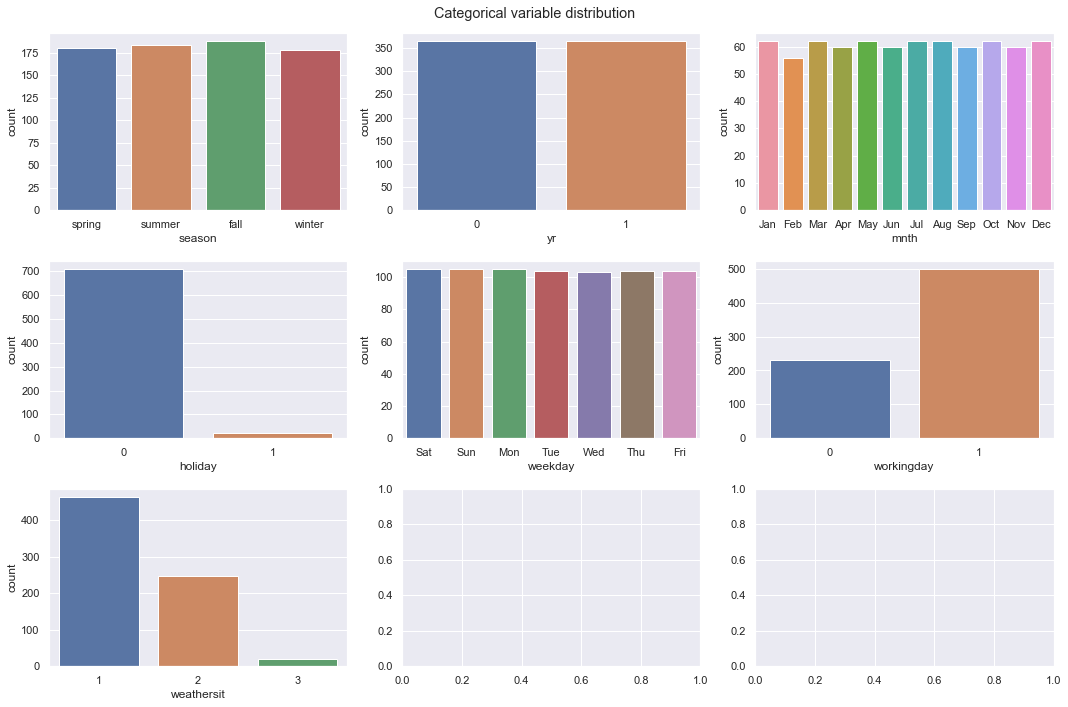

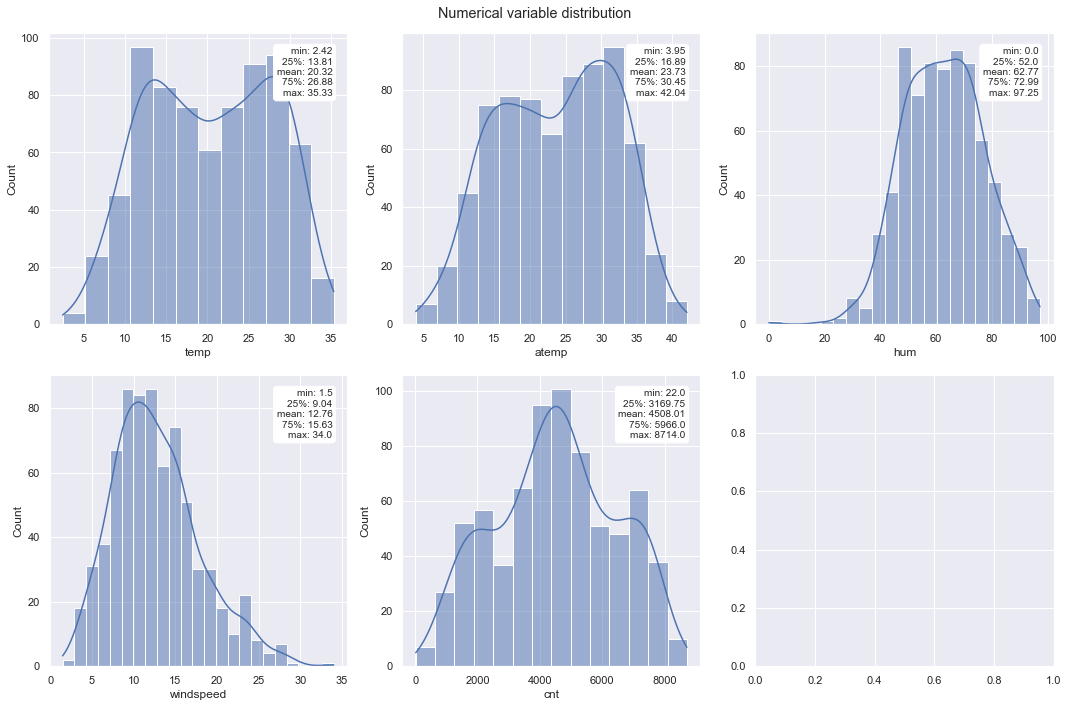

In [15]:
#Univariant analysis
#Subplot
fig,axs = plt.subplots(3,3,figsize=(15,10))
fig.suptitle('Categorical variable distribution')
axs = axs.flat
totals= []
for ax,column in zip(axs,cat_list):
    sns.countplot(x=bike_df[column],ax=ax)
plt.tight_layout()



fig,axs = plt.subplots(2,3,figsize=(15,10))
fig.suptitle('Numerical variable distribution')
axs = axs.flat
for ax, column in zip(axs, num_list):
    sns.histplot(bike_df[column],kde=True,ax=ax)
    desc = bike_df[column].describe()
    desc = round(desc, 2).apply(lambda x: str(x))
    box = '\n'.join(("min: "+desc["min"], "25%: "+desc["25%"], "mean: "+desc["mean"], "75%: "+desc["75%"], "max: "+desc["max"]))
    ax.text(0.95, 0.95, box, transform=ax.transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
plt.tight_layout()

# Multivariat analysis

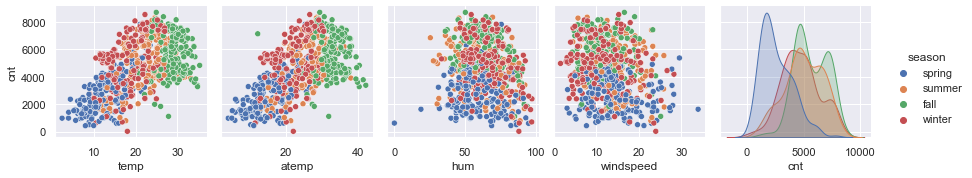

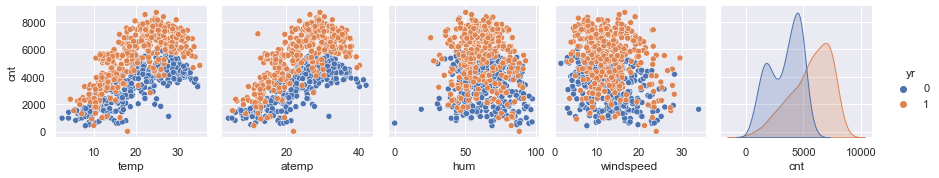

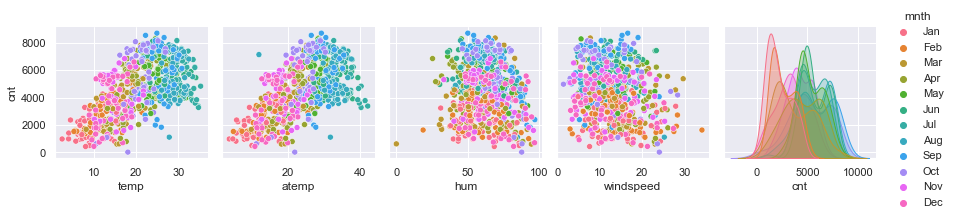

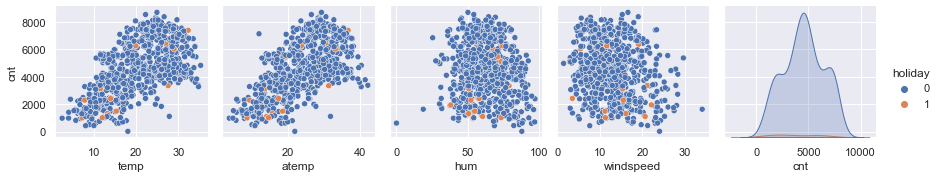

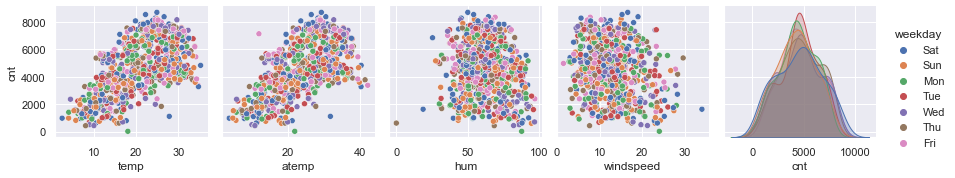

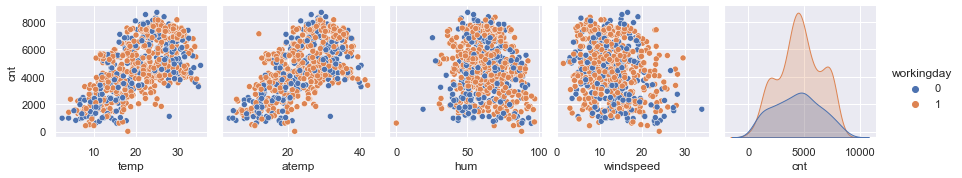

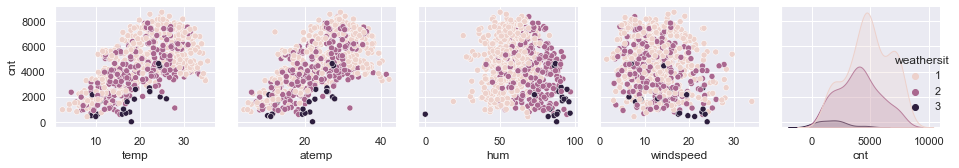

In [16]:
# Adding category variable as legends
# Pairplot for numerical variable with hue on categorical variables
numvar_df = bike_df[num_list]
for i in range(0, len(cat_list)):
    hue_cat = str(cat_list[i])
    sns.pairplot(bike_df, x_vars=num_list,y_vars=['cnt'],hue=hue_cat)
plt.tight_layout()

###  Correlation Analysis

##### examines the linear correlation between variable pairs. And this is can be achieved by combining corr() function with sns.heatmap() .

<AxesSubplot:>

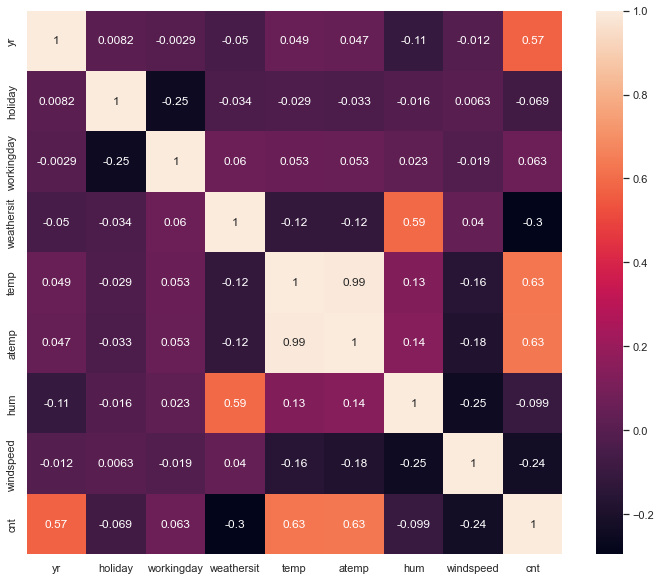

In [17]:
plt.figure(column,figsize=(12,10))
correlation = bike_df.corr()
sns.heatmap(correlation, annot=True)

#### Finding from above pairplot and heatmap
- atemp and temp are highly correlated, so we can keep one of the variable and drop the other
- Pairplot shows the categorical distrubution on the numerical variables- Lot of insights can be drawn from this like 
       - 2019 had more bike rentals, 
       - winter and fall season have high bike hires.
       - Similarly how good weather situation(weathersit) links to high bike rentals. 
       - bike hires are less on holidays
       - Weekdays have the highest bike hire
##### Droping atemp
- we found atemp and temp are highly correlated and are similar from heatmap and pairplot(from above Multivariat analysis)


In [18]:
bike_df.drop(columns=['atemp'], inplace=True)

## 2. Feature Engineering

In [19]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,Jan,0,Sat,0,2,14.110847,80.5833,10.749882,985
1,spring,0,Jan,0,Sun,0,2,14.902598,69.6087,16.652113,801
2,spring,0,Jan,0,Mon,1,1,8.050924,43.7273,16.636703,1349
3,spring,0,Jan,0,Tue,1,1,8.200000,59.0435,10.739832,1562
4,spring,0,Jan,0,Wed,1,1,9.305237,43.6957,12.522300,1600


#### Dummy variable encoding done for the variables identified in previous steps

In [20]:
#Dummy variable
bike_enc = pd.get_dummies(data=bike_df, columns=['season','mnth','weekday'],drop_first=True)
bike_enc.shape

(730, 28)

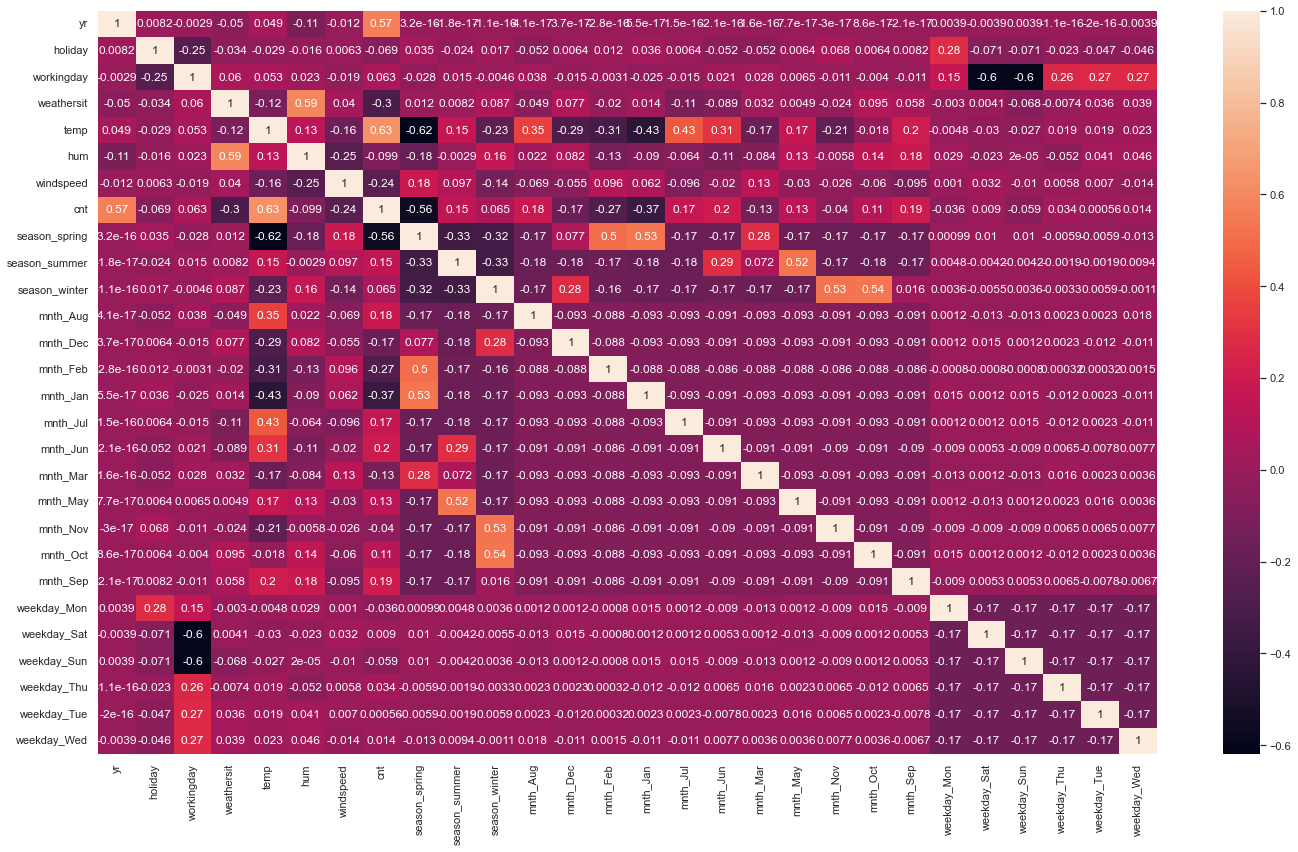

In [21]:
# Checking corelation again with all variables
plt.figure(column,figsize=(20,12))
correlation = bike_enc.corr()
sns.heatmap(correlation, annot=True)
plt.tight_layout()

## 3. Modeling
### Supervised learning
* The y column is cnt. It will help to predict the correct count.

In [22]:
# Split data and create training set and testing set
#y = bike_df.pop('cnt')
#X = bike_df

In [23]:
# Create training and testing sets: with 75-25% split with no rows repeating in both set.
bikef_train, bikef_test = model_selection.train_test_split(bike_enc, test_size=0.25, random_state=50)

### Scale the feature
* As this is a regression problems, best practice is to scale both input and target variables
* Min-max scaler is used

In [24]:
# Rescaling training set
scaler = MinMaxScaler()
bikefs_train = scaler.fit_transform(bikef_train)
scale_train = pd.DataFrame(bikefs_train, columns=bikef_train.columns,index=bikef_train.index)
#scale_train.head()

# Rescaling test set
bikefs_test = scaler.fit_transform(bikef_test)
scale_test = pd.DataFrame(bikefs_test, columns=bikef_test.columns,index=bikef_test.index)

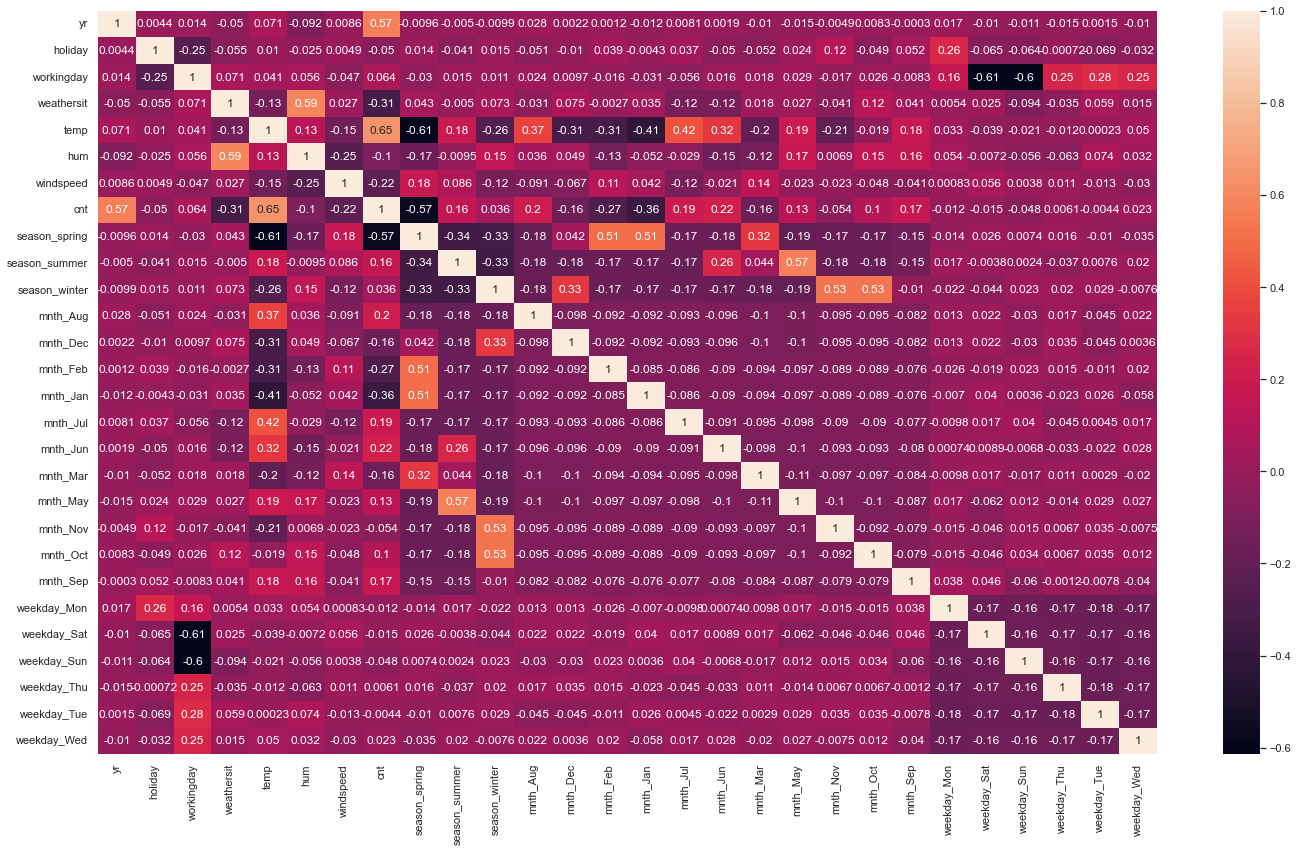

In [25]:
# Checking corelation again with all variables after scaling
plt.figure(column,figsize=(20,12))
correlation = scale_train.corr()
sns.heatmap(correlation, annot=True)
plt.tight_layout()

In [26]:
# Training set X and y variables 
y_train = scale_train.pop('cnt')
X_train = scale_train

# Test set X and y variables 
y_test = scale_test.pop('cnt')
X_test = scale_test

In [27]:
# print info
print("X_train shape:", X_train.shape, ", X_test shape:", X_test.shape)
print("y_train mean:", round(np.mean(y_train),2), ", y_test mean:", round(np.mean(y_test),2))
print(X_train.shape[1],"features:", X_train.columns.to_list())

X_train shape: (547, 27) , X_test shape: (183, 27)
y_train mean: 0.51 , y_test mean: 0.51
27 features: ['yr', 'holiday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'season_spring', 'season_summer', 'season_winter', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed']


In [28]:
bikef_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 98 to 688
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   yr             547 non-null    int64  
 1   holiday        547 non-null    int64  
 2   workingday     547 non-null    int64  
 3   weathersit     547 non-null    int64  
 4   temp           547 non-null    float64
 5   hum            547 non-null    float64
 6   windspeed      547 non-null    float64
 7   cnt            547 non-null    int64  
 8   season_spring  547 non-null    uint8  
 9   season_summer  547 non-null    uint8  
 10  season_winter  547 non-null    uint8  
 11  mnth_Aug       547 non-null    uint8  
 12  mnth_Dec       547 non-null    uint8  
 13  mnth_Feb       547 non-null    uint8  
 14  mnth_Jan       547 non-null    uint8  
 15  mnth_Jul       547 non-null    uint8  
 16  mnth_Jun       547 non-null    uint8  
 17  mnth_Mar       547 non-null    uint8  
 18  mnth_May 

#### Feature selection and Check Multicollinearity
- Looking into correlation between X variables

We did feature elimination before in EDA. Here we will deal with multicollinearity. 
- We didn't find any unusal very high correlation between X variables.

#### RFE Technique

In [29]:
# Initialize and fit linear model
lm = LinearRegression()
_= lm.fit(X_train, y_train)
lm.score(X_test,y_test)


0.8087980252852951

#####  The 0.80 R-squared looks good. We could go with all 28 features but this this doesn't xplaint the details. 
##### And Rsquared is estimating strength of relationshp, but doesn't tell the entire story
##### Using SKlearn to look into feature weights(or coefficients)

In [30]:
# Check the computed coefficents
pd.DataFrame(
    zip(X_train.columns, abs(lm.coef_)),
    columns=["feature", "coef"],
).sort_values("coef").reset_index(drop=True)

,feature,coef
0,mnth_Mar,0.003402
1,weekday_Thu,0.013883
2,mnth_Oct,0.014871
3,mnth_Jul,0.014930
4,weekday_Sun,0.017284
5,mnth_Aug,0.017308
6,weekday_Tue,0.017989
7,mnth_Jun,0.018490
8,weekday_Wed,0.018600
9,season_summer,0.027512


##### Insight:
- The coeffcient values near to zero, which can be removed. Since these are multipled by values of feature, such small values will contribute little to overall prediction.
- In Next steps we would use RFE to eliminite these in order using step by step method. As removing a single feature can have influence on other coefficent.

In [31]:
#Run RFE
# define the method,Selecting around 16 features, with cofficient values > 0.25 from initial cofficients
rfe = RFE(estimator=lm,n_features_to_select=18)
#fit the model
rfe = rfe.fit(X_train, y_train)
# list ranking of selected variables
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), X_train.columns,rfe.support_)))

Features sorted by their rank:
[(1, 'holiday', True), (1, 'hum', True), (1, 'mnth_Aug', True), (1, 'mnth_Dec', True), (1, 'mnth_Feb', True), (1, 'mnth_Jan', True), (1, 'mnth_May', True), (1, 'mnth_Nov', True), (1, 'mnth_Sep', True), (1, 'season_spring', True), (1, 'season_summer', True), (1, 'season_winter', True), (1, 'temp', True), (1, 'weathersit', True), (1, 'weekday_Sat', True), (1, 'windspeed', True), (1, 'workingday', True), (1, 'yr', True), (2, 'mnth_Jun', False), (3, 'weekday_Mon', False), (4, 'mnth_Oct', False), (5, 'mnth_Jul', False), (6, 'weekday_Sun', False), (7, 'weekday_Wed', False), (8, 'weekday_Tue', False), (9, 'weekday_Thu', False), (10, 'mnth_Mar', False)]


In [32]:
# Variables with significant weight are choosen
rfe_var=X_train.columns[rfe.support_]
rfe_var

Index(['yr', 'holiday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_May', 'mnth_Nov', 'mnth_Sep',
       'weekday_Sat'],
      dtype='object')

#### Model 1:

In [33]:
# Creating dataset with RFE selected variables
X_train_rfe=X_train[rfe_var]
X_train_rfe.head()

,yr,holiday,workingday,weathersit,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_May,mnth_Nov,mnth_Sep,weekday_Sat
98,0.0,0.0,0.0,0.5,0.353092,0.904250,0.189757,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
396,1.0,0.0,1.0,0.0,0.510926,0.523401,0.310919,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
175,0.0,0.0,0.0,0.0,0.792325,0.498067,0.355294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
454,1.0,0.0,0.0,0.5,0.454854,0.760841,0.444127,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
234,0.0,0.0,1.0,0.0,0.724830,0.469300,0.219363,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Calculate the VIFs

In [34]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,hum,32.85
4,temp,18.22
7,season_spring,6.07
2,workingday,5.96
6,windspeed,4.78
9,season_winter,4.36
8,season_summer,3.70
3,weathersit,2.63
13,mnth_Jan,2.13
12,mnth_Feb,2.02


In [35]:
# Add constant
X_train_lm1 = sm.add_constant(X_train_rfe)

# Create a model
lr1 = sm.OLS(y_train, X_train_lm1).fit()

# Print Summary
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     156.5
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          3.68e-198
Time:                        18:52:19   Log-Likelihood:                 548.79
No. Observations:                 547   AIC:                            -1060.
Df Residuals:                     528   BIC:                            -977.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3254      0.039      8.430

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


##### Droping variable from above findings
- Removing variable 'hum' as we getiing high VIF


#### Model 2:

In [36]:
# Drop hum column
X_train_2 = X_train_rfe.drop(["hum"], axis = 1)

In [37]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_2.columns
vif['VIF'] = [variance_inflation_factor(X_train_2.values, i) for i in range(X_train_2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,temp,7.10
2,workingday,5.90
5,windspeed,4.68
6,season_spring,4.68
8,season_winter,3.21
7,season_summer,3.16
12,mnth_Jan,2.03
11,mnth_Feb,2.00
0,yr,1.98
16,weekday_Sat,1.97


In [38]:
# Add constant
X_train_lm2 = sm.add_constant(X_train_2)

# Create a model
lr2 = sm.OLS(y_train, X_train_lm2).fit()

# Check parameters
lr2.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const            0.228476
yr               0.234952
holiday         -0.051150
workingday       0.036531
weathersit      -0.195464
temp             0.402881
windspeed       -0.150011
season_spring   -0.066918
season_summer    0.039584
season_winter    0.105501
mnth_Aug         0.018582
mnth_Dec        -0.065318
mnth_Feb        -0.029116
mnth_Jan        -0.061443
mnth_May         0.010419
mnth_Nov        -0.077288
mnth_Sep         0.072042
weekday_Sat      0.046040
dtype: float64

In [39]:
# Print Summary
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     155.5
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          5.53e-193
Time:                        18:52:19   Log-Likelihood:                 533.72
No. Observations:                 547   AIC:                            -1031.
Df Residuals:                     529   BIC:                            -954.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2285      0.035      6.488

##### Droping variable from above findings
- Removing variable 'mnth_May' as we getting high p-value and VIF


#### Model 3:

In [40]:
# Drop mnth_May column
X_train_3 = X_train_2.drop(["mnth_May"], axis = 1)

In [41]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_3.columns
vif['VIF'] = [variance_inflation_factor(X_train_3.values, i) for i in range(X_train_3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,temp,6.97
2,workingday,5.88
6,season_spring,4.67
5,windspeed,4.61
8,season_winter,3.21
7,season_summer,2.48
12,mnth_Jan,2.03
11,mnth_Feb,2.00
0,yr,1.98
15,weekday_Sat,1.96


In [42]:
# Add constant
X_train_lm3 = sm.add_constant(X_train_3)

# Create a model
lr3 = sm.OLS(y_train, X_train_lm3).fit()

# Check parameters
lr3.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const            0.224883
yr               0.234770
holiday         -0.050585
workingday       0.036404
weathersit      -0.194892
temp             0.407814
windspeed       -0.151146
season_spring   -0.064814
season_summer    0.044731
season_winter    0.106823
mnth_Aug         0.018682
mnth_Dec        -0.064442
mnth_Feb        -0.028596
mnth_Jan        -0.060561
mnth_Nov        -0.076498
mnth_Sep         0.072350
weekday_Sat      0.045549
dtype: float64

In [43]:
# Print Summary
print(lr3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     165.3
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          5.14e-194
Time:                        18:52:19   Log-Likelihood:                 533.52
No. Observations:                 547   AIC:                            -1033.
Df Residuals:                     530   BIC:                            -959.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2249      0.035      6.476

##### Droping variable from above findings
- Removing variable 'mnth_Aug' as we getiing high VIF

#### Model 4:

In [44]:
# Drop mnth_Aug column
X_train_4 = X_train_3.drop(["mnth_Aug"], axis = 1)

In [45]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_4.columns
vif['VIF'] = [variance_inflation_factor(X_train_4.values, i) for i in range(X_train_4.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,temp,6.10
2,workingday,5.82
5,windspeed,4.60
6,season_spring,4.39
8,season_winter,2.91
11,mnth_Jan,2.03
10,mnth_Feb,2.00
7,season_summer,1.99
0,yr,1.98
14,weekday_Sat,1.94


In [46]:
# Add constant
X_train_lm4 = sm.add_constant(X_train_4)

# Create a model
lr4 = sm.OLS(y_train, X_train_lm4).fit()

# Print Summary
print(lr4.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     176.2
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          6.71e-195
Time:                        18:52:20   Log-Likelihood:                 532.93
No. Observations:                 547   AIC:                            -1034.
Df Residuals:                     531   BIC:                            -965.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2334      0.034      6.902

##### Droping variable from above findings
- Removing variable 'mnth_Feb' as we getiing high VIF

#### Model 5:

In [47]:
# Drop mnth_Feb column
X_train_5= X_train_4.drop(["mnth_Feb"], axis = 1)

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_5.columns
vif['VIF'] = [variance_inflation_factor(X_train_5.values, i) for i in range(X_train_5.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,temp,6.06
2,workingday,5.81
5,windspeed,4.60
6,season_spring,2.93
8,season_winter,2.87
7,season_summer,1.99
0,yr,1.97
13,weekday_Sat,1.94
11,mnth_Nov,1.83
3,weathersit,1.60


In [48]:
# Add constant
X_train_lm5 = sm.add_constant(X_train_5)

# Create a model
lr5 = sm.OLS(y_train, X_train_lm5).fit()

# Print Summary
print(lr5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     188.3
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          1.30e-195
Time:                        18:52:20   Log-Likelihood:                 531.90
No. Observations:                 547   AIC:                            -1034.
Df Residuals:                     532   BIC:                            -969.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2241      0.033      6.750

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


##### Droping variable from above findings
- Removing variable 'mnth_Jan' as we getiing high VIF

#### Model 6:

In [49]:
# Drop mnth_Jan column
X_train_6= X_train_5.drop(["mnth_Jan"], axis = 1)

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_6.columns
vif['VIF'] = [variance_inflation_factor(X_train_6.values, i) for i in range(X_train_6.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,temp,6.00
2,workingday,5.77
5,windspeed,4.60
8,season_winter,2.86
6,season_spring,2.46
7,season_summer,1.99
0,yr,1.97
12,weekday_Sat,1.92
10,mnth_Nov,1.82
3,weathersit,1.60


In [50]:
# Add constant
X_train_lm6 = sm.add_constant(X_train_6)

# Create a model
lr6 = sm.OLS(y_train, X_train_lm6).fit()

# Print Summary
print(lr6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     200.3
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          2.03e-195
Time:                        18:52:20   Log-Likelihood:                 528.68
No. Observations:                 547   AIC:                            -1029.
Df Residuals:                     533   BIC:                            -969.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2032      0.032      6.291

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


##### Droping variable from above findings
- Removing variable 'workingday' as we getiing high VIF

#### Model 7:

In [51]:
# Drop Workingday column
X_train_7= X_train_6.drop(["workingday"], axis = 1)

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_7.columns
vif['VIF'] = [variance_inflation_factor(X_train_7.values, i) for i in range(X_train_7.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,windspeed,4.58
3,temp,3.85
7,season_winter,2.73
5,season_spring,2.04
0,yr,1.97
6,season_summer,1.89
9,mnth_Nov,1.81
2,weathersit,1.57
8,mnth_Dec,1.46
10,mnth_Sep,1.20


In [52]:
# Add constant
X_train_lm7 = sm.add_constant(X_train_7)

# Create a model
lr7 = sm.OLS(y_train, X_train_lm7).fit()

# Print Summary
print(lr7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     212.9
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          1.44e-194
Time:                        18:52:20   Log-Likelihood:                 523.88
No. Observations:                 547   AIC:                            -1022.
Df Residuals:                     534   BIC:                            -965.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2311      0.031      7.401

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### Findings until this stage
- Our prefered model is model 6
- From Model 7 we see removing workingday has higher p-values for weekday_Sat and the Adjusted R-squared decrease. so we will go back to Model 6.
- As of Model 6  we see p-value and VIF undercontrol, except the 'temp',Temperature. 
- Temperature can be an important factor for bike rental so we are not dropiing it.
- Model 6 has adjusted R-squared of 0.83. The VIF of feature is also very low compared to other models.

In [53]:
# Printing model summary for Model 6.
print(lr6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     200.3
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          2.03e-195
Time:                        18:52:20   Log-Likelihood:                 528.68
No. Observations:                 547   AIC:                            -1029.
Df Residuals:                     533   BIC:                            -969.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2032      0.032      6.291

### Additional details from model 6:
- All coefficient are not zero so we reject the null hypothesis.
- F-statiscs is 200( which is greater than 1)
- P-values are near to zero.

### Step: Residual Analysis and LR Assumptions
    

In [54]:
y_train_pred = lr6.predict(X_train_lm6)

#### 1. Error Terms are normally disributed

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

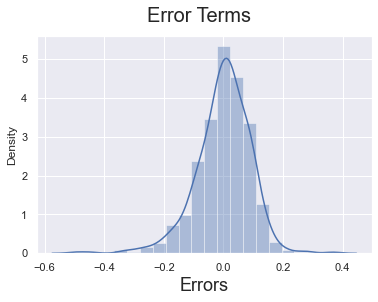

In [55]:
# resudual calculation 
residual = y_train - y_train_pred
# Plot histogram of the error terms
fig = plt.figure()
sns.distplot(residual, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

#### Error Terms are normally Distributed with mean Zero.

#### 2. Linearity exists and error terms are independent
- look into patterns of residuals

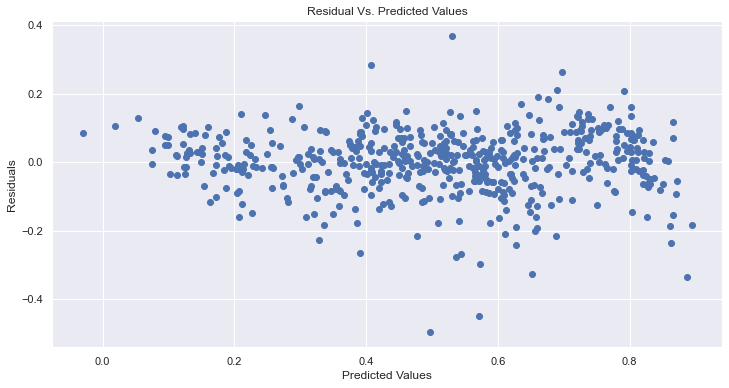

In [56]:
plt.figure(figsize = (12,6))
plt.scatter(y_train_pred,residual)
plt.title('Residual Vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

##### No pattern can be seen in the error terms wrt prediction. And the spread is even, so we can say the error terms are independent of each other.

#### 3. Homoscedasticity

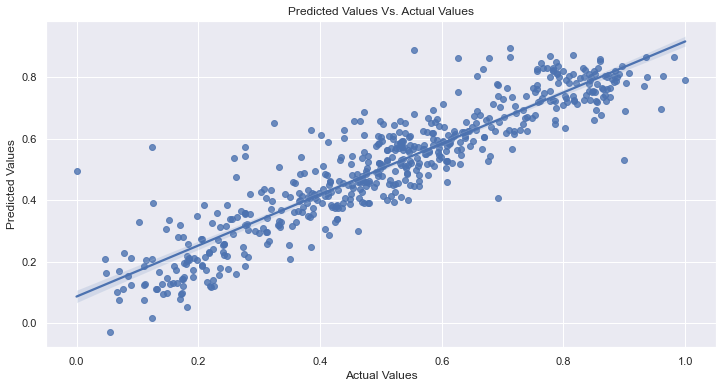

In [57]:
plt.figure(figsize = (12,6))
sns.regplot(x=y_train, y=y_train_pred)
plt.title('Predicted Values Vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

##### The  Error Terms have a Constant Variance(approximately), Hence the model follows the Assumption of Homoscedasticity

#### 4. No multi collinearity

In [58]:
vif = pd.DataFrame()
vif['Features'] = X_train_6.columns
vif['VIF'] = [variance_inflation_factor(X_train_6.values, i) for i in range(X_train_6.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,temp,6.00
2,workingday,5.77
5,windspeed,4.60
8,season_winter,2.86
6,season_spring,2.46
7,season_summer,1.99
0,yr,1.97
12,weekday_Sat,1.92
10,mnth_Nov,1.82
3,weathersit,1.60


## Predicting using final model

#### Test set check

In [59]:
# Test set was scaled before using minmax scaling technique
X_test.describe()

,yr,holiday,workingday,weathersit,temp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,...,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,0.540984,0.038251,0.633880,0.188525,0.544405,0.497738,0.415346,0.240437,0.245902,0.240437,...,0.043716,0.076503,0.087432,0.136612,0.131148,0.158470,0.169399,0.136612,0.109290,0.147541
std,0.499685,0.192329,0.483065,0.269777,0.250654,0.210100,0.196806,0.428521,0.431802,0.428521,...,0.205023,0.266530,0.283242,0.344380,0.338488,0.366183,0.376133,0.344380,0.312858,0.355617
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.346547,0.346710,0.275323,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.554388,0.479109,0.397141,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.500000,0.741722,0.648492,0.536922,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
# Select final variables
selected_cols= X_train_6.columns
print(selected_cols)

Index(['yr', 'holiday', 'workingday', 'weathersit', 'temp', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Dec',
       'mnth_Nov', 'mnth_Sep', 'weekday_Sat'],
      dtype='object')


In [61]:
X_test=X_test[selected_cols]
# Adding constant variable to test dataframe
X_test_lm6 = sm.add_constant(X_test)

X_test_lm6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 333 to 432
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   const          183 non-null    float64
 1   yr             183 non-null    float64
 2   holiday        183 non-null    float64
 3   workingday     183 non-null    float64
 4   weathersit     183 non-null    float64
 5   temp           183 non-null    float64
 6   windspeed      183 non-null    float64
 7   season_spring  183 non-null    float64
 8   season_summer  183 non-null    float64
 9   season_winter  183 non-null    float64
 10  mnth_Dec       183 non-null    float64
 11  mnth_Nov       183 non-null    float64
 12  mnth_Sep       183 non-null    float64
 13  weekday_Sat    183 non-null    float64
dtypes: float64(14)
memory usage: 21.4 KB


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
# predictions using the final model (lr6)

y_pred = lr6.predict(X_test_lm6)

### Visuals of the prediction

Text(0, 0.5, 'y_pred')

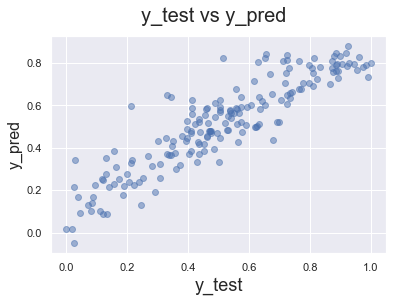

In [63]:
fig = plt.figure()
plt.scatter(y_test, y_pred, alpha=.5)
fig.suptitle('y_test vs y_pred', fontsize = 20) 
plt.xlabel('y_test', fontsize = 18)
plt.ylabel('y_pred', fontsize = 16) 

#### R-squared and Adj R-squared check for Test set

In [64]:
from sklearn.metrics import r2_score
r2=r2_score(y_test, y_pred)
print(r2)

0.8130543215966619


In [65]:
# number of rows in X
n = X_test.shape[0]


# Number of features
p = X_test.shape[1]

# Adjusted R-squared
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adjusted_r2

0.7986738847964051

In [66]:
# Show all cofficients
cofficients = round(lr6.params,2)
beta = cofficients.sort_values(ascending = False)
beta

temp             0.44
yr               0.23
const            0.20
season_winter    0.10
mnth_Sep         0.07
weekday_Sat      0.05
workingday       0.04
season_summer    0.04
holiday         -0.05
mnth_Dec        -0.05
mnth_Nov        -0.07
season_spring   -0.09
windspeed       -0.15
weathersit      -0.19
dtype: float64

In [67]:
# best fit line
for i in range(0, len(beta)):
    print(beta[i],'*',beta.index[i],end ='')
    print(' + ',end ='')

0.44 * temp + 0.23 * yr + 0.2 * const + 0.1 * season_winter + 0.07 * mnth_Sep + 0.05 * weekday_Sat + 0.04 * workingday + 0.04 * season_summer + -0.05 * holiday + -0.05 * mnth_Dec + -0.07 * mnth_Nov + -0.09 * season_spring + -0.15 * windspeed + -0.19 * weathersit + 

# Summary Report
- Model 6 seems to be a good model. We got Adj R-square for training: 0.82 and test: 0.80. This model can generalize and predict demand from new data set
- Top predictor variables:
    - temperature(temp): coefficient of 0.442, indicates a unit increase in temeprature variable will increase the bike hire number by 0.442.
    - year: coefficient of 0.234, indicates a unit increase in year will increase the bike hire number by 0.234.
    - weather Situation(weathersit): coefficient of -0.1932, indicates if the weather situation gets bad by one level then bike hire number goes down by -0.193.
    - windspeed: coefficient of -0.145, indicates if the wind speed increases one unit, the bike hire goes down by -0.145.
    - Season(season_winter): coefficient of 0.105, indicates in winter season the bike hire goes up by  0.105
- Note: weather Situation levels are detailed in the data description.
